In [1]:
import os, torch, torchvision, random, copy
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torchsummary import summary

In [2]:
!unzip /content/drive/MyDrive/segDATA.zip

Archive:  /content/drive/MyDrive/segDATA.zip
   creating: segDATA/
   creating: segDATA/nscrew/
  inflating: segDATA/nscrew/00048035_FILE0_L2.bmp  
  inflating: segDATA/nscrew/00048035_FILE0_L4.bmp  
  inflating: segDATA/nscrew/00048035_FILE0_T11.bmp  
  inflating: segDATA/nscrew/00048035_FILE0_T2.bmp  
  inflating: segDATA/nscrew/00048035_FILE0_T7.bmp  
  inflating: segDATA/nscrew/00048035_FILE1_L2.bmp  
  inflating: segDATA/nscrew/00048035_FILE1_L4.bmp  
  inflating: segDATA/nscrew/00048035_FILE1_T12.bmp  
  inflating: segDATA/nscrew/00048035_FILE3_L1.bmp  
  inflating: segDATA/nscrew/00048035_FILE3_L2.bmp  
  inflating: segDATA/nscrew/00048035_FILE3_L4.bmp  
  inflating: segDATA/nscrew/00048035_FILE3_T11.bmp  
  inflating: segDATA/nscrew/00048035_FILE3_T7.bmp  
  inflating: segDATA/nscrew/00048035_FILE4_L3.bmp  
  inflating: segDATA/nscrew/01142281_FILE0_T3.bmp  
  inflating: segDATA/nscrew/01142281_FILE0_T4.bmp  
  inflating: segDATA/nscrew/01142281_FILE0_T9.bmp  
  inflating: segD

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
class VertexDataset(Dataset):

    def __init__(self, filenames, labels, transform):

        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):

        return len(self.filenames)

    def __getitem__(self, idx):

        img = Image.open(self.filenames[idx])
        # img = TF.adjust_contrast(img, 4)
        label = np.array(self.labels[idx])

        img = self.transform(img)

        return img, label

In [6]:
train_transformer = transforms.Compose([
    transforms.Resize([224, 224]),
    # transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5]),
])

test_transformer = transforms.Compose([
    transforms.Resize([224, 224]),
    # transforms.CenterCrop([224,224]),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5]),
])

def split_Train_Val_Data(data_dir):

    dataset = ImageFolder(data_dir)

    # two classes
    character = [[], []]

    # sace filename to corresponding list
    for x, y in dataset.samples:
      character[y].append(x)

    train_inputs, test_inputs = [], []
    train_labels, test_labels = [], []

    for i, data in enumerate(character):

      np.random.seed(69)
      np.random.shuffle(data)

      mid = int(len(data)*0.8)

      train_inputs.extend(data[:mid])
      train_labels.extend( [ i for d in range(len(data[:mid]))] )

      test_inputs.extend(data[mid:])
      test_labels.extend( [ i for d in range(len(data[mid:]))] )

    train_dataloader = DataLoader(VertexDataset(train_inputs, train_labels, train_transformer), batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(VertexDataset(test_inputs, test_labels, test_transformer), batch_size = batch_size, shuffle = False)

    return train_dataloader, test_dataloader    

In [7]:
class BuildModel(nn.Module):

    def __init__(self):
        
        super(BuildModel, self).__init__()
        
        # ----------------------------------------------
        # 初始化模型的 layer (input size: 224 * 224)

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2)
        )

        # ----------------------------------------------
               
    def forward(self, x):
        
        # ----------------------------------------------
        # Forward (final output 1 probability)

        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        # ----------------------------------------------

        return x

In [8]:
batch_size = 256
lr = 1e-2
m = 0.9
wd = 0.01
epochs = 300

data_dir = '/content/segDATA'

In [9]:
train_dataloader, test_dataloader = split_Train_Val_Data(data_dir)

C = BuildModel().to(device) # 使用內建的 model 或是自行設計的 model
optimizer_C = optim.SGD(C.parameters(), lr = lr, momentum = m, weight_decay = wd) # 選擇你想用的 optimizer

summary(C, (1,224 ,224)) # 利用 torchsummary 的 summary package 印出模型資訊，input size: (224 * 224)

# Loss function
criteron = nn.CrossEntropyLoss() # 選擇想用的 loss function

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]           7,808
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
        MaxPool2d-11            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-12            [-1, 256, 6, 6]               0
          Dropout-13                 [-1, 9216]               0
           Linear-14                 [-

In [10]:
loss_epoch_C = []
train_acc, test_acc = [], []
best_acc, best_auc = 0.0, 0.0
best_model = None

In [11]:
if __name__ == '__main__':    
    
    for epoch in range(epochs):
    
        iter = 0
        correct_train, total_train = 0, 0
        correct_test, total_test = 0, 0
        train_loss_C = 0.0

        C.train() # 設定 train 或 eval
      
        print('epoch: ' + str(epoch + 1) + ' / ' + str(epochs))  
        
        # ---------------------------
        # Training Stage
        # ---------------------------
        
        for i, (x, label) in enumerate(train_dataloader) :
                     
            x, label = x.to(device), label.to(device)
                        
            optimizer_C.zero_grad() # 清空梯度
            
            outputs = C(x) # 將訓練資料輸入至模型進行訓練

            loss = criteron(outputs, label.long()) # 計算 loss
            
            loss.backward() # 將 loss 反向傳播
            optimizer_C.step() # 更新權重
            
            # 計算訓練資料的準確度 (correct_train / total_train)
            _, predicted = torch.max(outputs, 1)
            total_train += label.size(0)
            correct_train += (predicted == label).sum().item()

            train_loss_C += loss.item()
            iter += 1
                    
        print('Training epoch: %d / loss_C: %.3f | acc: %.3f' % \
              (epoch + 1, train_loss_C / iter, correct_train / total_train))

        
        # --------------------------
        # Testing Stage
        # --------------------------
        
        C.eval() # 設定 train 或 eval
          
        for i, (x, label) in enumerate(test_dataloader) :
          
            with torch.no_grad(): # 測試階段不需要求梯度
                x, label = x.to(device), label.to(device)
                
                outputs = C(x) # 將測試資料輸入至模型進行測試 
                
                _, predicted = torch.max(outputs, 1)
                total_test += label.size(0)
                correct_test += (predicted == label).sum().item()
        
        print('Testing acc: %.3f' % (correct_test / total_test))
        train_acc.append(100 * correct_train/total_train) # training accuracy
        test_acc.append(100 * correct_test/total_test)  # testing accuracy
        loss_epoch_C.append(train_loss_C) # loss 

        if (train_acc[-1] + test_acc[-1])/2 > best_acc:
          best_acc = (train_acc[-1] + test_acc[-1])/2
          best_model = copy.deepcopy(C)
    

epoch: 1 / 300
Training epoch: 1 / loss_C: 0.693 | acc: 0.501
Testing acc: 0.500
epoch: 2 / 300
Training epoch: 2 / loss_C: 0.693 | acc: 0.497
Testing acc: 0.500
epoch: 3 / 300
Training epoch: 3 / loss_C: 0.693 | acc: 0.506
Testing acc: 0.530
epoch: 4 / 300
Training epoch: 4 / loss_C: 0.693 | acc: 0.550
Testing acc: 0.500
epoch: 5 / 300
Training epoch: 5 / loss_C: 0.693 | acc: 0.539
Testing acc: 0.500
epoch: 6 / 300
Training epoch: 6 / loss_C: 0.692 | acc: 0.507
Testing acc: 0.500
epoch: 7 / 300
Training epoch: 7 / loss_C: 0.692 | acc: 0.522
Testing acc: 0.500
epoch: 8 / 300
Training epoch: 8 / loss_C: 0.692 | acc: 0.570
Testing acc: 0.585
epoch: 9 / 300
Training epoch: 9 / loss_C: 0.691 | acc: 0.606
Testing acc: 0.570
epoch: 10 / 300
Training epoch: 10 / loss_C: 0.690 | acc: 0.519
Testing acc: 0.520
epoch: 11 / 300
Training epoch: 11 / loss_C: 0.691 | acc: 0.504
Testing acc: 0.510
epoch: 12 / 300
Training epoch: 12 / loss_C: 0.690 | acc: 0.502
Testing acc: 0.515
epoch: 13 / 300
Traini

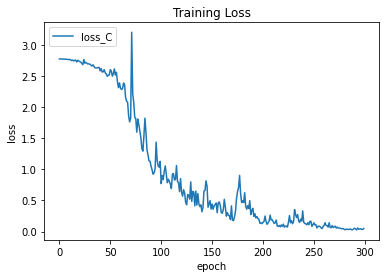

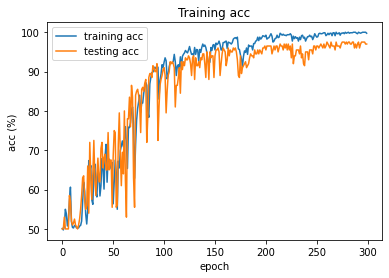

In [12]:
plt.figure()

plt.plot(loss_epoch_C) # plot your loss

plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
plt.show()

plt.figure()

plt.plot(train_acc) # plot your training accuracy
plt.plot(test_acc) # plot your testing accuracy

plt.title('Training acc')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.show()

In [13]:
torch.save(best_model, './screw_clf(2).pt')